In [1]:
library(anndata)
library(Matrix)


library(SingleCellExperiment)

library(here)

library(edgeR)

library(foreach)
library(doParallel)

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges

### Parameters

In [2]:
adjPvalThr = 0.01
FCthr = 1.5

## Loading data

In [3]:
adata_path <- here("03_downstream_analysis/02_gene_universe_definition/results/01_INFLAMMATION_annotated_pseudobulk.h5ad")

In [4]:
psdata <- read_h5ad(adata_path)
psdata

AnnData object with n_obs × n_vars = 7357 × 14101
    obs: 'studyID', 'sampleID', 'chemistry', 'disease', 'sex', 'binned_age', 'Level1', 'psbulk_n_cells', 'psbulk_counts', 'disease_cat'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status'

In [5]:
# makes sure that clinical covariates are available. Otherwise drop the patients
psdata = psdata[!is.na(psdata$obs$binned_age)]
psdata = psdata[!is.na(psdata$obs$sex)]

### Convert anndata to *SingleCellExperiment* format

In [6]:
# Generating the SingleExperimentObject. 
# Notice that the count matrix has to be transposed because in sce rows include genes, while columns include samples.
sce <- SingleCellExperiment(list(counts=t(psdata$X)), 
                           colData = DataFrame(psdata$obs),
                           rowData = DataFrame(psdata$var),
                           metadata=list(experiment_info="inflammationAtlas"))

In [7]:
unique(sce$Level1)

[1] B              DC             ILC            Mono           Plasma        
 [6] T_CD4_Naive    T_CD4_NonNaive T_CD8_Naive    T_CD8_NonNaive UTC           
[11] pDC           
11 Levels: B DC ILC Mono Plasma T_CD4_Naive T_CD4_NonNaive ... pDC

In [8]:
# merging togheter the two version of 5' sequencing protocol 

# colData(sce)$mainChem <- as.character(colData(sce)$ILCIC_chemistry)
# colData(sce)$mainChem[startsWith(x = colData(sce)$mainChem, '5_prime')] <- '5_prime'
# colData(sce)$mainChem <- as.factor(colData(sce)$mainChem)

In [9]:
diseases <- unique(colData(sce)$disease)

In [10]:
conditionPairs<- t(combn(as.character(diseases), 2, simplify = TRUE))

In [11]:
conditionPairsFilt <- conditionPairs[(conditionPairs[,1] == 'healthy' | conditionPairs[,2] == 'healthy'),]
#conditionPairsFilt <- conditionPairs

**For each condition pair and for each cell-type:**

subset the sce object to keep only a pair of conditions

In [12]:
n.cores <- 19
my.cluster <- parallel::makeCluster(
  n.cores, 
  type = "PSOCK"
  )

#check cluster definition (optional)
print(my.cluster)

socket cluster with 19 nodes on host ‘localhost’


In [13]:
#register it to be used by %dopar%
doParallel::registerDoParallel(cl = my.cluster)
#check if it is registered (optional)
foreach::getDoParRegistered()

[1] TRUE

In [14]:
annotationCol = 'Level1'

In [15]:
logFile <- here(paste0('03_downstream_analysis/02_gene_universe_definition/results/DEGlogFile_', format(Sys.time(), "%s"), '.txt'))
TTfinal <- DataFrame()
TTfinal <- foreach(cP_i = 1:dim(conditionPairsFilt)[1],
                   .combine = 'rbind',
                   .packages = c('edgeR', 'SingleCellExperiment')) %dopar% {
# for(cP_i in 1:dim(conditionPairsFilt)[1]) {
    diseaseA <- conditionPairsFilt[cP_i,1]
    diseaseB <- conditionPairsFilt[cP_i,2]

    # healthy vs. other
    if(diseaseB == 'healthy') {
        diseaseB = diseaseA
        diseaseA = 'healthy'
    }

    
    # subset sce object to keep only selected diseases 
    sce_conditionsAB <- sce[,(colData(sce)$disease == diseaseA | colData(sce)$disease == diseaseB)]

    # remove celltype with less than 2 patients
    TctA <- table(colData(sce_conditionsAB)[[annotationCol]][colData(sce_conditionsAB)$disease == diseaseA])
    TctB <- table(colData(sce_conditionsAB)[[annotationCol]][colData(sce_conditionsAB)$disease == diseaseB])
    
    sce_condition_filt <- sce_conditionsAB[,((sce_conditionsAB[[annotationCol]] %in% names(TctA)[TctA >= 3] ) & 
                                             (sce_conditionsAB[[annotationCol]] %in% names(TctB)[TctB >= 3] ))]



    # cat(file = logFile, append = TRUE, 'Cell types included: ', paste0(unique(sce_condition_filt$cell_mainGroup_21Sep23), join = ', '))

    cellTypes <- unique(sce_condition_filt[[annotationCol]])

    # cat(file = logFile, append = TRUE, sep = '',
    #         diseaseA, ' vs. ', diseaseB,' -- Cell-type considered: ',paste0(unique(sce[[annotationCol]]), collapse = ', '),
    #         '\n')
        
    # for each cell types included
    DEGfinal <- data.frame()
    
    for(cellType_i in cellTypes){
        
        sce_condition_ct_filt <- sce_condition_filt[,sce_condition_filt[[annotationCol]] == cellType_i]
    
        # create the edgeR object
        y <- DGEList(counts(sce_condition_ct_filt), samples=colData(sce_condition_ct_filt))

        # filter genes by expression
        keep <- filterByExpr(y, group = sce_condition_ct_filt$disease)
        y <- y[keep,]
    
        # cat(file = logFile, append = TRUE, 'Gene kept (removed): ',summary(keep)[3],' (',summary(keep)[2],')')

        # normalize expression
        y <- calcNormFactors(y, logratioTrim = 0.3)        
        
        # defining the design
        # The idea is to correct for main sequencing protocol (i.e., 3'v2, 3'v3, and 5') and for sex (m,f)
        # Unfortunatelly, not all the condition pair are sequenced with different protocols, 
        # so here we check if there are at least 2 different factor for each covariate to create an appropriet design      
        desFormula <- '~0 + factor(disease) + factor(chemistry)'
        # if(length(unique(y$samples$chemistry)) > 1){
        #     desFormula <- paste(desFormula, '+ factor(chemistry)')
        # }
        if(length(unique(y$samples$sex)) > 1){
            desFormula <- paste(desFormula, '+ factor(sex)')
        }
        if(length(unique(y$samples$binned_age)) > 1){
            desFormula <- paste(desFormula, '+ factor(binned_age)')
        }
        
        # cat(file = logFile, append = TRUE, 'design: ', desFormula)

        cat(file = logFile, append = TRUE, sep = '',
            diseaseA, ' vs. ', diseaseB,' ', cP_i,'/',dim(conditionPairsFilt)[1], 
            '. ', cellType_i,
            '. Gene kept(removed): ',summary(keep)[3],' (',summary(keep)[2],')',
            '. Design: ', desFormula, 
            '\n')
        
        design <- model.matrix(object = formula(desFormula), y$samples)
        
        # estimate dispersion
        # cat(file = logFile, append = TRUE, 'Estimating dispersion')

        y <- tryCatch(y <- estimateDisp(y, design), 
                      error = function(e) { 
                        cat(file = logFile, append = TRUE, sep = '',
                        diseaseA, ' vs. ', diseaseB,' ', cP_i,'/',dim(conditionPairsFilt)[1], 
                        '. ', cellType_i, ' FAILED!\n')
                          y <- NULL
                      })
        
        if(is.null(y)) { 
            next 
        }     
        
        # fit a quasi-likelihood model
        # cat(file = logFile, append = TRUE, 'Quasi-likelihood fitting')
        fit <- tryCatch(fit <- glmQLFit(y, design, robust=TRUE), 
                      error = function(e) { 
                        cat(file = logFile, append = TRUE, sep = '',
                        diseaseA, ' vs. ', diseaseB,' ', cP_i,'/',dim(conditionPairsFilt)[1], 
                        '. ', cellType_i, ' FAILED!\n')
                          fit <- NULL
                      })
        
        if(is.null(fit)) { 
            next 
        }     

        # defining contrasts (first and second column includes the two conditions
        contrast <- numeric(length(colnames(fit$coefficients)))
        contrast[which(endsWith(colnames(fit$coefficients),paste0(')',diseaseA)))] <- 1
        contrast[which(endsWith(colnames(fit$coefficients),paste0(')',diseaseB)))] <- -1

        # cat(file = logFile, append = TRUE, 'DEG testing')
        res <- glmQLFTest(fit, contrast=contrast)       

        # result extraction
        DEGres <- summary(decideTests(res))
        
        nDEGs <- DEGres['Up',] + DEGres['Down',]

        # select only DEGs
        TT <- topTags(res, n = Inf)

        # cat(file = logFile, append = TRUE, '# DEGs: ', nDEGs)
        
        # Adding comparison information
        TT$table['conditions'] <- paste0(diseaseA,'_vs_',diseaseB)
        TT$table['cellType'] <- cellType_i
        TT$table['genes'] <- rownames(TT$table)
        rownames(TT$table) <- NULL
    
        # merge results with previous data
        DEGfinal <- rbind(DEGfinal, TT$table)
    }

    # TTfinal <- rbind(TTfinal, DEGfinal)
    return(DEGfinal)
    
}


In [16]:
parallel::stopCluster(cl = my.cluster)

In [17]:
TTfinal$FDRfinal <- p.adjust(p = TTfinal$PValue, method = 'BH')

In [18]:
DEG <- unique(TTfinal$genes[TTfinal$FDRfinal < adjPvalThr & abs(TTfinal$logFC) > FCthr])
disease <- TTfinal$conditions[TTfinal$FDRfinal < adjPvalThr & abs(TTfinal$logFC) > FCthr]

In [19]:
length(DEG)

[1] 6868

In [20]:
length(unique(disease))

[1] 19

In [21]:
TTfinal_DEGfilt <- TTfinal[TTfinal$FDRfinal < adjPvalThr & abs(TTfinal$logFC) > FCthr,]

In [22]:
write.table(x = TTfinal_DEGfilt, file = here('03_downstream_analysis/02_gene_universe_definition/results/03_DEhealthyVSothers_DEGsel.csv'), sep = '\t', col.names = TRUE, row.names = FALSE, quote = FALSE)

In [65]:
saveRDS(object = TTfinal, file = here('03_downstream_analysis/02_gene_universe_definition/results/03_DEhealthyVSothers_allGene.rds'))

In [66]:
write.table(x = TTfinal, file = here('03_downstream_analysis/02_gene_universe_definition/results/03_DEhealthyVSothers_allGene.csv'), sep = '\t', col.names = TRUE, row.names = FALSE, quote = FALSE)

### Exploring list of DEG - Healthy vs. each other condition

In [67]:
# Loading the results
TTfinal <-  readRDS(here('03_downstream_analysis/02_gene_universe_definition/results/03_DEhealthyVSothers_allGene.rds'))

In [68]:
DEG <- unique(TTfinal$genes[TTfinal$FDRfinal < adjPvalThr & abs(TTfinal$logFC) > FCthr])
length(DEG)

[1] 6868

In [69]:
table(TTfinal$conditions[TTfinal$FDRfinal < adjPvalThr & abs(TTfinal$logFC) > FCthr])


   healthy_vs_asthma      healthy_vs_BRCA        healthy_vs_CD 
                1377                 6592                 1368 
healthy_vs_cirrhosis      healthy_vs_COPD     healthy_vs_COVID 
                 906                  739                 1614 
      healthy_vs_CRC       healthy_vs_flu       healthy_vs_HBV 
                2985                 2041                 7510 
      healthy_vs_HIV     healthy_vs_HNSCC        healthy_vs_MS 
                4394                 1532                 4032 
      healthy_vs_NPC        healthy_vs_PS       healthy_vs_PSA 
                6602                 1624                 1450 
       healthy_vs_RA    healthy_vs_sepsis       healthy_vs_SLE 
                1425                 1208                  210 
       healthy_vs_UC 
                1541 

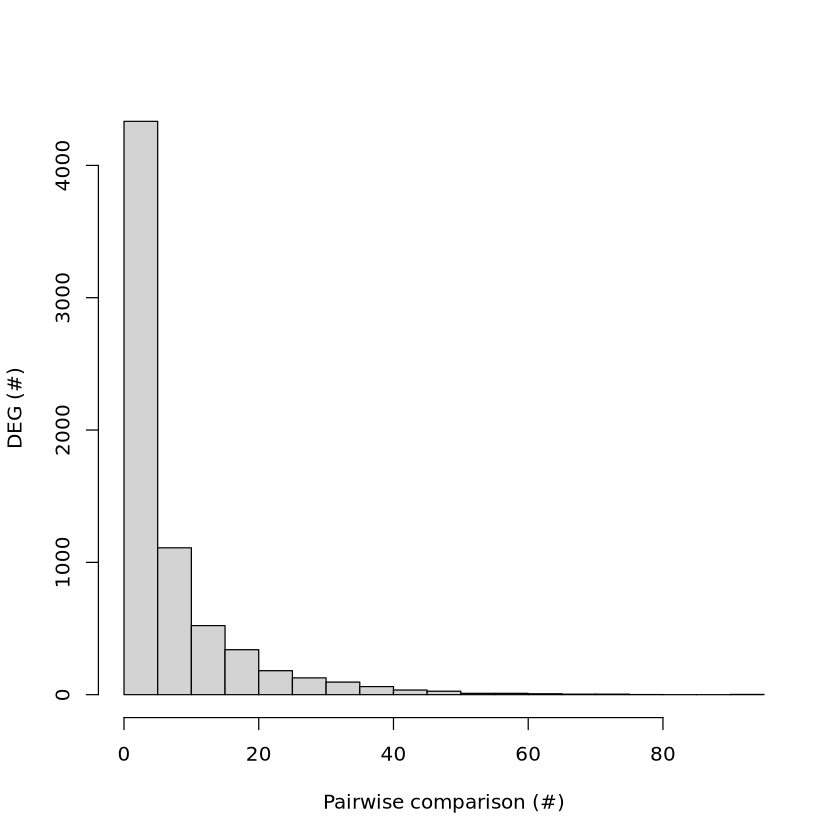

In [70]:
hist(table(TTfinal$genes[TTfinal$FDRfinal < adjPvalThr & abs(TTfinal$logFC) > FCthr]), 
     breaks = 20, 
     main = '',
     xlab="Pairwise comparison (#)", 
    ylab = 'DEG (#)')


In [71]:
DEGt <- DataFrame(DEG = DEG)
DEGt

DataFrame with 6868 rows and 1 column
                 DEG
         <character>
1    ENSG00000229809
2    ENSG00000119772
3    ENSG00000180011
4    ENSG00000196712
5    ENSG00000136504
...              ...
6864 ENSG00000037637
6865 ENSG00000198865
6866 ENSG00000175854
6867 ENSG00000105426
6868 ENSG00000198246

In [72]:
write.table(x = DEGt, quote = FALSE, sep = '\t', row.names = FALSE, col.names = TRUE,
            file = here('03_downstream_analysis/02_gene_universe_definition/results/03_DEG_healty_vs_others_list.csv'))